# Déforestation et croissance économique

## Introduction

La déforestation ne cesse d'augmenter à l'échelle globale selon les données de l'Organisation des Nations unies pour l'alimentation et l'agriculture (FAO), mais avec de grandes disparités selon les pays et régions du monde. La variation annuelle de la superficie forestière est largement négative en Afrique et en Amérique du Sud entre 2000 et 2020, alors qu'elle est positive ou presque nulle sur les autres continents. Cette variation de la surface de forêt peut être causée par des feux de forêts involontaires, mais elle est majoritairement due à une déforestation volontaire dans le but d'agrandir les terres agricoles ou de produire du bois par exemple. Ainsi, on peut imaginer qu'il existe un lien entre la déforestation et la croissance économique des pays. C'est d'ailleurs ce qu'ont montré Andrée et al (2019), qui trouvent une relation en U-inversé entre le revenu par habitant et la déforestation. López et Galinato (2005) ont aussi trouvé que la croissance économique explique certains facteurs de la déforestation tels que la pauvreté, l'expansion agricole et la construction de routes.
Notre projet consiste donc à étudier le lien entre la croissance économique et la déforestation par pays.



## 1. Récupération des données

Nous allons importer des données provenant de trois sources différentes :
- Les données sur le PIB issues de la Banque Mondiale grâce à une API. 
- Les données sur la production, exportation et importation de différents types de bois, issues de la FAO, importées en csv.
- Les données sur la déforestation (surface), issues de Global Forest Watch, grâce à un package sur python.

### 1.0. Installation des packages
Nous installons d'abord les packages nécéssaires au projet

In [11]:
%pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.1 MB/s eta 0:00:00


### 1.1 API de la Banque Mondiale

Pour obtenir les données de la Banque Mondiale, nous avons utilisé une API dont la documentation est disponible à cette adresse : https://datatopics.worldbank.org/world-development-indicators/ . 
Nous avons récupéré seulement la variable du PIB (en US$). Le code tourne pendant environ 1 minute.

In [8]:
## récupérer les données de l'API de la Banque Mondiale 
import requests
import pandas as pd

# fonction permettant de choisir l'indicateur et les années qu'on souhaite récupérer :

def fetch_worldbank_data(indicator, start_date="1960", end_date="2024"):
    
    base_url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={start_date}:{end_date}&format=json"
    all_records = []
    page = 1

    url = f"{base_url}&page={page}"
    req = requests.get(url)
    data_eco = req.json()
# déterminer le nombre de pages non vides
    if len(data_eco) > 0 and isinstance(data_eco[0], dict) and "pages" in data_eco[0]:
        total_pages = data_eco[0]["pages"]
        print(f"{indicator} - Nombre total de pages : {total_pages}")
    else:
        print(f"{indicator} - Impossible de déterminer le nombre de pages.")
        return None
# faire tourner le code jusqu'à la dernière page
    while page <= total_pages:
        url = f"{base_url}&page={page}"
        req = requests.get(url)
        data_eco = req.json()

        if len(data_eco) > 1 and isinstance(data_eco[1], list):
            all_records.extend(data_eco[1])
        page += 1

    df = pd.DataFrame(all_records)

    if "country" in df.columns and "date" in df.columns and "value" in df.columns:
        # Extraire le nom du pays depuis le dictionnaire dans la colonne 'country'
        df["country"] = df["country"].apply(lambda x: x["value"] if isinstance(x, dict) else x)
        table = df[["date", "value", "country"]]
        return table
    else:
        print(f"{indicator} - Les colonnes attendues ne sont pas disponibles.")
        return None


data_BM= fetch_worldbank_data("NY.GDP.MKTP.CD", start_date="1960", end_date="2024")
data_BM=data_BM.rename(columns={"value" : "PIB"})

NY.GDP.MKTP.CD - Nombre total de pages : 341


In [9]:
data_BM

,date,PIB,country
0,2023,1.245472e+12,Africa Eastern and Southern
1,2022,1.191423e+12,Africa Eastern and Southern
2,2021,1.085745e+12,Africa Eastern and Southern
3,2020,9.333918e+11,Africa Eastern and Southern
4,2019,1.009721e+12,Africa Eastern and Southern
...,...,...,...
17019,1964,1.217138e+09,Zimbabwe
17020,1963,1.159512e+09,Zimbabwe
17021,1962,1.117602e+09,Zimbabwe
17022,1961,1.096647e+09,Zimbabwe


Pour pouvoir merger les données de la banque mondiale avec celles des deux autres bases de données nous utilisons les codes pays avec le package pycountry pour obtenir les codes pays iso 3166.

In [ ]:
import pycountry

# Fonction pour récupérer le code pays ISO 3166
def get_country_code(country_name):
    try:
        # Recherche dans pycountry
        country = pycountry.countries.lookup(country_name)
        return country.alpha_3  # Retourne le code à 3 lettres
    except LookupError:
        return None  # Si le pays n'est pas trouvé

# Ajouter une colonne 'code_pays' avec les codes ISO 3166
data_BM['code_pays'] = data_BM['country'].apply(get_country_code)


,date,PIB,country,code_pays
0,2023,1.245472e+12,Africa Eastern and Southern,None
1,2022,1.191423e+12,Africa Eastern and Southern,None
2,2021,1.085745e+12,Africa Eastern and Southern,None
3,2020,9.333918e+11,Africa Eastern and Southern,None
4,2019,1.009721e+12,Africa Eastern and Southern,None
...,...,...,...,...
17019,1964,1.217138e+09,Zimbabwe,ZWE
17020,1963,1.159512e+09,Zimbabwe,ZWE
17021,1962,1.117602e+09,Zimbabwe,ZWE
17022,1961,1.096647e+09,Zimbabwe,ZWE


In [15]:
df_nan_pib = data_BM[data_BM["PIB"].isnull()]
df_nan_pib

,date,PIB,country,code_pays
191,1960,NaN,Arab World,None
290,1989,NaN,Central Europe and the Baltics,None
291,1988,NaN,Central Europe and the Baltics,None
292,1987,NaN,Central Europe and the Baltics,None
293,1986,NaN,Central Europe and the Baltics,None
...,...,...,...,...
16891,1964,NaN,"Yemen, Rep.",None
16892,1963,NaN,"Yemen, Rep.",None
16893,1962,NaN,"Yemen, Rep.",None
16894,1961,NaN,"Yemen, Rep.",None


Pour l'instant, il y a beaucoup de données maquantes (Nan), mais nous allons par la suite merger avec d'autres données et réduire la plage d'années utilisées.

## 2. Analyse descriptive des données

Dans cette partie, nous allons faire une analyse descriptive des données 

In [114]:
# installer les packages
# %pip install geopandas
# %pip install pandas
# %pip install nbformat
# %pip install plotly
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn

# Charger les packages 
import pandas as pd
import os
import nbformat


In [115]:
# Afficher le répertoire de travail actuel
print(os.getcwd())

/home/onyxia/work/Deforestation/MainPython


On peut donc maintenant fusionner toutes nos données en un seul tableau bien formaté, le merge se fait sur l'année et le code pays car les trois bases de données n'utilisent pas les mêmes conventions pour les noms de pays 

In [116]:
# Importer les données obtenues précédement
data_BM = pd.read_csv('/home/onyxia/work/Deforestation/Données/data_BM.csv')
data_FAO_pivot = pd.read_csv('/home/onyxia/work/Deforestation/Données/CSV_FAO/data_FAO_pivot.csv', sep=";")
data_owid = pd.read_csv('/home/onyxia/work/Deforestation/Données/df_owid.csv')


# On merge les données de la FAO et de la Banque Mondiale
data_1 = pd.merge(data_BM, data_FAO_pivot, left_on=['code_pays', 'date'], right_on=['code_pays', 'Year'], how='inner')

# On merge les données ainsi obtenues avec les données de Our World In Data
data = pd.merge(data_1, data_owid, left_on=['code_pays', 'date'], right_on=['code_pays', 'year'] )

# On supprime les colonnes inutiles et on remet la colonne 'country' et 'year' en première position
data = data.drop(columns= ['country_x','country_y','date','year'] )
data = data.rename(columns={'Area' : 'country'})
columns = ['country','Year'] + [col for col in data if (col != 'Year' and col != 'country')]
data = data[columns]

data

,country,Year,PIB,GINI,Part terres agricoles,Part terres foret,code_pays,Export quantity - Fibreboard,Export quantity - Industrial roundwood,Export quantity - Paper and paperboard,...,"Production - Wood chips, particles and residues",Production - Wood fuel,"Production - Wood pellets, briquettes and other agglomerates",commodity_driven_deforestation,forestry,shifting_agriculture,unknown,urbanization,wildfire,total
0,Afghanistan,2001,2.813572e+09,0.0,57.947350,1.852782,AFG,0.0,2038.0,112.00,...,0.0,1314150.0,0.0,0.000000,31.753510,0.000000,56.339203,0.000000,0.000000,88.092710
1,Albania,2001,3.922101e+09,0.0,41.569343,28.123248,ALB,1226.0,25000.0,1094.00,...,0.0,186600.0,0.0,0.000000,2205.439700,73.184525,48.615932,0.000000,1401.781000,3729.021000
2,Algeria,2001,5.941340e+10,0.0,16.840209,0.677194,DZA,0.0,0.0,0.00,...,0.0,7188295.0,0.0,198.382280,499.730440,1559.410400,129.407500,336.517360,745.312300,3468.760300
3,Andorra,2001,1.548266e+09,0.0,48.404255,34.042553,AND,0.0,72.0,17.00,...,0.0,0.0,0.0,0.000000,0.057020,0.000000,0.969052,0.000000,0.628141,1.654213
4,Angola,2001,8.936079e+09,0.0,35.626053,61.886219,AGO,0.0,1300.0,82.00,...,0.0,3240601.0,0.0,2.512755,265.225340,98079.340000,2412.978000,0.000000,460.560180,101220.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,Uzbekistan,2023,1.015918e+11,0.0,0.000000,0.000000,UZB,8212.0,0.0,14916.00,...,36.0,11428.0,0.0,0.000000,0.000000,0.175452,0.338339,0.000000,0.000000,0.513791
3509,Vanuatu,2023,1.126313e+09,0.0,0.000000,0.000000,VUT,228.0,1662.0,203.00,...,0.0,91000.0,0.0,16.347303,6.635110,806.230350,10.421369,0.000000,0.000000,839.634160
3510,Viet Nam,2023,4.297170e+11,0.0,0.000000,0.000000,VNM,200547.0,18610.0,2067361.00,...,18450000.0,20000000.0,4740000.0,33523.220000,67764.450000,33846.140000,22.841860,158.947620,0.000000,135315.610000
3511,Zambia,2023,2.757796e+10,0.0,0.000000,0.000000,ZMB,110.0,25740.0,350.99,...,201000.0,23033000.0,46000.0,2.005270,0.684082,190196.110000,38.219566,151.211750,28.354399,190416.580000


In [117]:
column_names = data.columns.tolist()
print(column_names)


['country', 'Year', 'PIB', 'GINI', 'Part terres agricoles', 'Part terres foret', 'code_pays', 'Export quantity - Fibreboard', 'Export quantity - Industrial roundwood', 'Export quantity - Paper and paperboard', 'Export quantity - Roundwood', 'Export quantity - Wood chips, particles and residues', 'Export quantity - Wood fuel', 'Export quantity - Wood pellets, briquettes and other agglomerates', 'Export value - Fibreboard', 'Export value - Industrial roundwood', 'Export value - Paper and paperboard', 'Export value - Roundwood', 'Export value - Wood chips, particles and residues', 'Export value - Wood fuel', 'Export value - Wood pellets, briquettes and other agglomerates', 'Import quantity - Fibreboard', 'Import quantity - Industrial roundwood', 'Import quantity - Paper and paperboard', 'Import quantity - Roundwood', 'Import quantity - Wood chips, particles and residues', 'Import quantity - Wood fuel', 'Import quantity - Wood pellets, briquettes and other agglomerates', 'Import value - Fi

In [118]:
# création de la variable du total de production de bois et changement du nom de la variable 'total' (qui correspond à la surface total déforestée) pour éviter les confusions

data['Total_Production'] = data.filter(like='Production').sum(axis=1)
data = data.rename(columns={'total' : 'Total_deforestation(ha)'})
data

,country,Year,PIB,GINI,Part terres agricoles,Part terres foret,code_pays,Export quantity - Fibreboard,Export quantity - Industrial roundwood,Export quantity - Paper and paperboard,...,Production - Wood fuel,"Production - Wood pellets, briquettes and other agglomerates",commodity_driven_deforestation,forestry,shifting_agriculture,unknown,urbanization,wildfire,Total_deforestation(ha),Total_Production
0,Afghanistan,2001,2.813572e+09,0.0,57.947350,1.852782,AFG,0.0,2038.0,112.00,...,1314150.0,0.0,0.000000,31.753510,0.000000,56.339203,0.000000,0.000000,88.092710,6148300.0
1,Albania,2001,3.922101e+09,0.0,41.569343,28.123248,ALB,1226.0,25000.0,1094.00,...,186600.0,0.0,0.000000,2205.439700,73.184525,48.615932,0.000000,1401.781000,3729.021000,532000.0
2,Algeria,2001,5.941340e+10,0.0,16.840209,0.677194,DZA,0.0,0.0,0.00,...,7188295.0,0.0,198.382280,499.730440,1559.410400,129.407500,336.517360,745.312300,3468.760300,14854490.0
3,Andorra,2001,1.548266e+09,0.0,48.404255,34.042553,AND,0.0,72.0,17.00,...,0.0,0.0,0.000000,0.057020,0.000000,0.969052,0.000000,0.628141,1.654213,0.0
4,Angola,2001,8.936079e+09,0.0,35.626053,61.886219,AGO,0.0,1300.0,82.00,...,3240601.0,0.0,2.512755,265.225340,98079.340000,2412.978000,0.000000,460.560180,101220.620000,8673002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,Uzbekistan,2023,1.015918e+11,0.0,0.000000,0.000000,UZB,8212.0,0.0,14916.00,...,11428.0,0.0,0.000000,0.000000,0.175452,0.338339,0.000000,0.000000,0.513791,184687.0
3509,Vanuatu,2023,1.126313e+09,0.0,0.000000,0.000000,VUT,228.0,1662.0,203.00,...,91000.0,0.0,16.347303,6.635110,806.230350,10.421369,0.000000,0.000000,839.634160,258000.0
3510,Viet Nam,2023,4.297170e+11,0.0,0.000000,0.000000,VNM,200547.0,18610.0,2067361.00,...,20000000.0,4740000.0,33523.220000,67764.450000,33846.140000,22.841860,158.947620,0.000000,135315.610000,156829940.0
3511,Zambia,2023,2.757796e+10,0.0,0.000000,0.000000,ZMB,110.0,25740.0,350.99,...,23033000.0,46000.0,2.005270,0.684082,190196.110000,38.219566,151.211750,28.354399,190416.580000,51698000.0


Création de la variable de croissance du PIB

In [119]:
# Trier les données par Pays et Année
data = data.sort_values(by=['country', 'Year']).reset_index(drop=True)
data
# Calcul de la croissance du PIB par pays
data['Croissance_PIB'] = data.groupby('code_pays')['PIB'].pct_change() * 100
data

,country,Year,PIB,GINI,Part terres agricoles,Part terres foret,code_pays,Export quantity - Fibreboard,Export quantity - Industrial roundwood,Export quantity - Paper and paperboard,...,"Production - Wood pellets, briquettes and other agglomerates",commodity_driven_deforestation,forestry,shifting_agriculture,unknown,urbanization,wildfire,Total_deforestation(ha),Total_Production,Croissance_PIB
0,Afghanistan,2001,2.813572e+09,0.0,57.947350,1.852782,AFG,0.0,2038.0,112.0,...,0.0,0.000000,31.75351,0.0000,56.339203,0.000000,0.000000,88.09271,6148300.0,NaN
1,Afghanistan,2002,3.825701e+09,0.0,57.939684,1.852782,AFG,0.0,10000.0,22.0,...,0.0,0.000000,67.85075,0.0000,110.789610,0.000000,0.000000,178.64037,6221252.0,35.973125
2,Afghanistan,2003,4.520947e+09,0.0,58.083805,1.852782,AFG,396.0,34074.0,161.0,...,0.0,0.000000,113.22104,0.0000,131.115220,0.000000,0.000000,244.33626,6296352.0,18.173017
3,Afghanistan,2004,5.224897e+09,0.0,58.151266,1.852782,AFG,396.0,99987.0,198.0,...,0.0,0.000000,131.22055,0.0000,70.224400,0.000000,0.000000,201.44495,6373664.0,15.570851
4,Afghanistan,2005,6.203257e+09,0.0,58.134400,1.852782,AFG,396.0,99987.0,198.0,...,0.0,0.000000,102.62120,0.0000,133.335630,0.000000,0.000000,235.95683,6453258.0,18.724960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,Zimbabwe,2019,2.571741e+10,50.3,39.518358,45.213002,ZWE,12338.0,40656.0,5134.0,...,0.0,1.382205,6526.89840,4999.3896,12.587267,1.833442,11.238701,11553.33000,19966700.0,-24.706180
3509,Zimbabwe,2020,2.686794e+10,0.0,39.754073,45.093912,ZWE,10729.0,24000.0,1272.0,...,0.0,1.017816,2693.83150,3496.3782,17.037254,2.787108,13.867128,6224.91900,20094248.0,4.473727
3510,Zimbabwe,2021,2.724052e+10,0.0,39.385906,44.974822,ZWE,9737.7,28406.0,4495.4,...,0.0,1.600864,2937.02470,6014.7360,68.924420,3.738736,28.462732,9054.48700,20511446.0,1.386704
3511,Zimbabwe,2022,3.278975e+10,0.0,39.489284,44.855732,ZWE,5995.0,20376.0,4223.0,...,0.0,4.023651,3659.49980,4522.8800,45.421550,3.960732,29.195229,8264.98000,20291543.0,20.371262


Un exemple avec les données de la Chine

In [120]:
data[data["code_pays"]=="CHN"]

,country,Year,PIB,GINI,Part terres agricoles,Part terres foret,code_pays,Export quantity - Fibreboard,Export quantity - Industrial roundwood,Export quantity - Paper and paperboard,...,"Production - Wood pellets, briquettes and other agglomerates",commodity_driven_deforestation,forestry,shifting_agriculture,unknown,urbanization,wildfire,Total_deforestation(ha),Total_Production,Croissance_PIB
738,China,2001,1.339401e+12,0.0,55.757872,19.104968,CHN,203304.00,27910.0,3196003.00,...,0.0,131.878740,188212.33,823.4999,7407.07760,1099.44130,32614.8890,230289.11,689580447.0,NaN
739,China,2002,1.470558e+12,42.0,55.821132,19.356454,CHN,388552.00,453466.0,3180839.00,...,0.0,39.068985,210108.97,1202.3387,6336.21340,1233.66100,30230.7030,249150.95,690873014.0,9.792196
740,China,2003,1.660281e+12,0.0,55.884389,19.607939,CHN,330232.00,19492.0,3567493.00,...,0.0,366.639740,186957.81,925.9517,3863.88700,927.33685,68719.8700,261761.50,715231136.0,12.901425
741,China,2004,1.955347e+12,0.0,55.947645,19.859423,CHN,466813.00,31228.0,3396218.00,...,0.0,252.165420,394846.44,1322.2778,6537.34860,2196.08180,96389.4900,501543.80,728562372.0,17.772070
742,China,2005,2.285961e+12,40.9,56.010903,20.110908,CHN,1706868.00,29259.0,3857174.00,...,0.0,299.226870,335931.72,1233.3147,4941.71880,1711.70900,39472.6600,383590.34,723297368.0,16.908222
743,China,2006,2.752119e+12,0.0,56.074160,20.362393,CHN,2320140.00,138231.0,4843833.00,...,0.0,450.864720,460428.56,2044.7043,6203.06300,2505.66400,103600.0200,575232.90,730860282.0,20.392189
744,China,2007,3.550328e+12,0.0,56.137418,20.613878,CHN,2055790.00,173207.0,5931715.00,...,0.0,405.053860,600354.10,2799.9065,6638.03760,3318.90750,39462.6680,652978.70,756300990.0,29.003442
745,China,2008,4.594337e+12,43.0,56.200672,20.865362,CHN,2781540.00,98979.0,4872327.00,...,0.0,504.363100,682823.60,2293.5690,6256.32670,3260.34200,42893.0500,738031.30,833746332.0,29.405988
746,China,2009,5.101691e+12,0.0,56.263925,21.116845,CHN,2215501.00,47394.0,4898997.00,...,0.0,732.101440,553008.44,2598.4326,5465.53760,3084.11080,34714.6130,599603.25,899274022.0,11.043038
747,China,2010,6.087192e+12,43.7,56.183473,21.368329,CHN,2330277.00,49330.0,4881489.00,...,0.0,337.067800,571005.00,3141.5098,5897.02250,3499.96900,43945.3400,627825.90,949044104.0,19.317136


## Analyse Descriptive

On va d'abord essayer de visualiser les liens entre la croissance du PIB, la production de bois et la surface déforestée

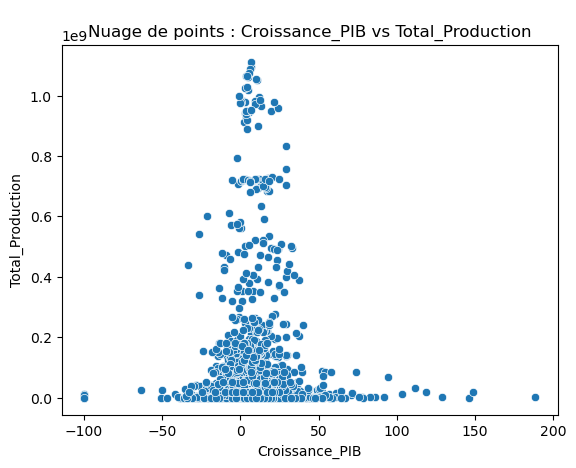

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer le nuage de points avec seaborn
sns.scatterplot(x='Croissance_PIB', y='Total_Production', data=data)

# Ajouter un titre
plt.title('Nuage de points : Croissance_PIB vs Total_Production')

# Afficher le graphique
plt.show()


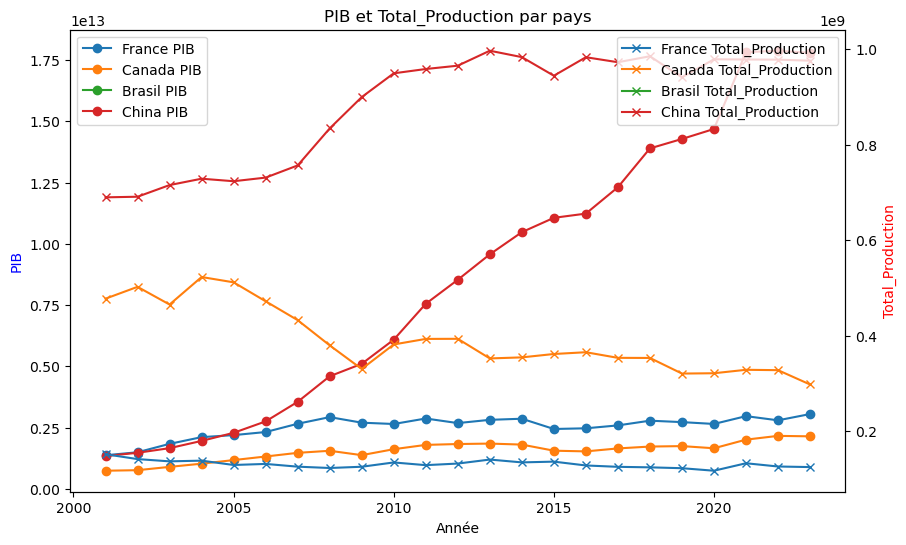

In [122]:
import matplotlib.pyplot as plt

# Liste des pays à afficher
pays_a_afficher = ['France', 'Canada', 'Brasil', 'China']

# Filtrer le DataFrame pour ne garder que les lignes correspondant à ces pays
filtered_data = data[data['country'].isin(pays_a_afficher)]

# Créer une figure et des axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer les lignes pour chaque pays (PIB sur le premier axe)
for pays in pays_a_afficher:
    # Filtrer les données pour chaque pays
    pays_data = filtered_data[filtered_data['country'] == pays]
    
    # Tracer la ligne pour PIB sur l'axe de gauche
    ax1.plot(pays_data['Year'], pays_data['PIB'], label=f'{pays} PIB', marker='o')

# Créer un deuxième axe des ordonnées pour Total_Production (axe de droite)
ax2 = ax1.twinx()

# Tracer les lignes pour Total_Production sur l'axe de droite
for pays in pays_a_afficher:
    # Filtrer les données pour chaque pays
    pays_data = filtered_data[filtered_data['country'] == pays]
    
    # Tracer la ligne pour Total_Production sur l'axe de droite
    ax2.plot(pays_data['Year'], pays_data['Total_Production'], label=f'{pays} Total_Production', marker='x')

# Ajouter des titres et des labels
ax1.set_title('PIB et Total_Production par pays')
ax1.set_xlabel('Année')
ax1.set_ylabel('PIB', color='blue')  # Axe gauche pour PIB
ax2.set_ylabel('Total_Production', color='red')  # Axe droite pour Total_Production

# Ajouter des légendes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Afficher le graphique
plt.show()



In [123]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

Mise en place d'une fonction permettant de créer une carte interactive sur plusieurs années

In [124]:
def carte_period(df,name): 
    # Étape 1 : Ajouter toutes les années manquantes (2001-2023) pour chaque pays
    all_years = list(range(2001, 2024))  # Inclut 2001-2023
    all_countries = df['country'].unique()

    # Créer toutes les combinaisons possibles de pays et années
    all_combinations = pd.MultiIndex.from_product([all_countries, all_years], names=["country", "Year"])
    df = df.set_index(["country", "Year"]).reindex(all_combinations).reset_index()


    # Étape 2 : Fixer l'échelle de couleurs pour toutes les années
    value_min = df[name].min()  # Valeur minimale globale
    value_max = df[name].max()  # Valeur maximale globale

    # Étape 3 : Créer la carte interactive
    fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color=name,
        animation_frame="Year",
        color_continuous_scale="Cividis",
        #range_color=[value_min, value_max],  # Fixer l'échelle de couleurs
        title="Carte interactive de "+name+" par année (2001-2023)"
    )

    # Ajuster la mise en page
    fig.update_layout(
        width=1200,  # Largeur de la carte
        height=600,  # Hauteur de la carte
        title_x=0.5,  # Centrer le titre
        geo=dict(
            showframe=False,  # Supprimer le cadre
            showcoastlines=True,  # Afficher les côtes
            projection_type='natural earth'  # Type de projection
        )
    )

    # Afficher la carte interactive
    fig.show()

On peut visualiser le volume de production total de bois par pays et par année entre 2001 et 2023

In [125]:
carte_period(data,'Total_Production')

On peut observer de grande disparité de production de bois (en volume) entre les différents pays du monde, mais les tendances globales se conservent sur la périodes temporelle étudiée. Ainsi on peut observer qui sont les plus grands producteurs de bois, dans l'ordre décroissant : les Etats-Unis, la Chine, l'Inde, le Brésil et la Russie.

On peut aussi visualiser la surface déforestée par pays et par années

In [126]:
carte_period(data,'Total_deforestation(ha)')

Contrairement à la production de bois par pays, la surface déforestée est beaucoup plus volatile. Elle peut, pour un même pays, grandement varier d'une année à l'autre comme on peut l'observer par exemple pour le Brésil entre 2015 et 2016. De plus, ce ne sont pas forcément les pays qui déforestent le plus qui ont la plus grande production de bois, d'où l'importance de séparer les deux variables.

Et pour finir, on peut visualiser notre troisième variable d'intérêt, la croissance du PIB (Les 0 obtenus pour la première année sont un artifice de calcul de la croissance du PIB)

In [127]:
carte_period(data,'Croissance_PIB')

Comme on pouvait s'y attendre la croissance du PIB varie beaucoup en fonction des pays et peut varier en fonction des années car elle est affectée par les crises économiques comme le Covid et la crise de 2008.

On peut ensuite créer un programme permettant d'afficher une carte interactive des quantités précédentes moyenné sur la période temporelle, nous donnant ainsi une idée du comportement global des pays depuis 2001

In [128]:
def carte_moyenne(df,name):

    # Calculer la moyenne des valeurs par pays
    average_data = df.groupby('country', as_index=False)[name].mean()
    average_data.rename(columns={name: 'Moyenne '+name}, inplace=True)

    # Créer la carte
    fig = px.choropleth(
        average_data,
        locations="country",           # Colonne des noms des pays
        locationmode="country names",  # Mode basé sur les noms de pays
        color='Moyenne '+name,         # Colonne des valeurs moyennes
        title="Valeur moyenne de "+name+" par pays",
        color_continuous_scale="Plasma"  # Palette de couleurs
    )

    # Ajuster la mise en page
    fig.update_layout(
        width=1200,  # Largeur de la carte
        height=600,  # Hauteur de la carte
        title_x=0.5,  # Centrer le titre
        geo=dict(
            showframe=False,  # Supprimer le cadre
            showcoastlines=True,  # Afficher les côtes
            projection_type='natural earth'  # Type de projection
        )
    )

    # Afficher la carte
    fig.show()

carte_moyenne(data,'Total_Production')
carte_moyenne(data,'Total_deforestation(ha)')
carte_moyenne(data,'Croissance_PIB')

Ces trois cartes nous permettent seulement d'avoir un comportement moyenné des quantités étudiés mais cela nous permet de bien nous rendre compte des principaux producteurs de bois mais aussi d'avoir une distinction plus nette entre les pays en voie de développement et les pays développés.

Pour avoir une meilleur idée des liens entre nos variables, on peut aussi faire un programme nous permettant d'observer qualitativement les corrélations entre les moyennes de deux colonnes de notre dataframe, nous permettant ainsi d'avoir une idée des résultats attendus pour les régressions linéaires.

In [129]:
import plotly.express as px

def nuage_inter(data,xval,yval):
    # Calculer la moyenne des deux colonnes par pays
    average_data = data.groupby('country', as_index=False)[[xval, yval]].mean()

    # Créer le nuage de points 2D sans gradient de couleur
    scatter = px.scatter(
        average_data,
        x=xval,        # Moyenne de 'value' pour l'axe X
        y=yval,       # Moyenne de 'value2' pour l'axe Y
        hover_name="country",  # Afficher le nom du pays en hover
        title= xval+" vs moyenne de "+yval+" (moyenne de 2001 à 2023)"
    )

    # Mettre l'axe y en échelle logarithmique
    scatter.update_layout(
        xaxis=dict(
            type='log',  # Échelle logarithmique pour l'axe y
            title='Moyenne de '+xval+' (échelle log)'  # Titre de l'axe y
        ),
        title=dict(
        x=0.5,  # Centrer le titre horizontalement
        xanchor='center'  # Ancrage du titre au centre
        ),
        yaxis=dict(
            type='log',  # Échelle logarithmique pour l'axe y
            title='Moyenne de '+yval+' (échelle log)'  # Titre de l'axe y
        ),
    )

    # Mettre à jour la présentation des points (couleur unie)
    scatter.update_traces(marker=dict(size=10, color='blue'))  # Utiliser une couleur unie

    # Affichage du graphique
    scatter.show()


In [130]:
nuage_inter(data,'Total_Production','Total_deforestation(ha)')

Ce nuage de point est très intéressant car au premier ordre, on se rend compte qu'il y a une relation linéaire empirique qui émerge en échelle log log, ainsi lors de l'étude quantitative il sera judicieux de regarder le logarithme de ces quantités et aussi leurs moyennes.

In [131]:
nuage_inter(data,'Total_Production','Croissance_PIB')
nuage_inter(data,'Total_deforestation(ha)','Croissance_PIB')

Ces deux graphes nous font constater qu'a contrario, la surface déforestée et la production volumique de bois ne semblent pas être des variables très explicatives du PIB.

In [132]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Pour faire les régressions avec la croissance, il nous est nécessaire de d'abord retirer les valeurs absurdes (infini et NaN). C'est pourquoi : 

In [133]:
data["Croissance_PIB"] = data["Croissance_PIB"].replace([float("inf"), float("-inf")], np.nan)
data= data.dropna(subset=["Croissance_PIB"])
data["Croissance_PIB"].max() # Pour visualiser que l'opération à bien fonctionner

np.float64(188.50455859329514)

Nous allons dans une copie du dataframe également retirer les valeurs négatives (ce qui sera nécessaire pour appliquer le log par la suite). 

In [134]:
# Ajouter une constante uniquement aux colonnes avec des problèmes (à valeurs négatives)
data_log = data.copy()
columns_with_problems = ["Croissance_PIB","Total_deforestation(ha)", "Total_Production"]

for col in columns_with_problems:
    data_log[col] = data_log[col] + abs(data_log[col].min())

Def de la fonction pour faire les régressions : 

    Effectue une régression linéaire avec validation croisée.
        Arguments :
            X : Variables explicatives.
            y : Variable cible.
            n_splits : Nombre de splits pour K-Fold ( à 10 si l'utilisateur ne précise pas)


In [135]:
def regression(X, y, n_splits=10):
    # Initialiser le modèle de régression linéaire
    model = LinearRegression()

    # Initialiser KFold
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Stocker les métriques et coefficients
    mse_scores = []
    r2_scores = []
    adjusted_r2_scores = []
    coefficients = []
    p_values = []

    # Effectuer la validation croisée
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train)

        # Faire des prédictions sur les données de test
        y_pred = model.predict(X_test)

        # Calcul des métriques
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)  # Nombre d'observations
        p = X_train.shape[1]  # Nombre de variables explicatives

        # Calcul du R^2 ajusté
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

        # Stocker les scores
        mse_scores.append(mse)
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)

        # Stocker les coefficients
        coeff = model.coef_
        coefficients.append(coeff)

        # Calcul des p-values
        X_with_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Ajouter constante
        y_hat = model.predict(X_train)
        residuals = y_train - y_hat
        sigma_squared = np.sum(residuals**2) / (len(y_train) - p - 1)
        var_beta = sigma_squared * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
        t_stats = model.coef_ / np.sqrt(var_beta[1:])
        p_vals = [2 * (1 - t.cdf(np.abs(t_stat), df=len(y_train) - p - 1)) for t_stat in t_stats]
        p_values.append(p_vals)

    # Résultats moyens
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    mean_coefficients = np.mean(coefficients, axis=0)
    mean_p_values = np.mean(p_values, axis=0)

    # Afficher les métriques moyennes
    print(f"Erreur quadratique moyenne (MSE) moyenne : {mean_mse}")
    print(f"Coefficient de détermination (R^2) moyen : {mean_r2}")
    print(f"R^2 ajusté moyen : {mean_adjusted_r2}")

    # Afficher les coefficients moyens et significativité
    for i, (coeff, p_val) in enumerate(zip(mean_coefficients, mean_p_values)):
        print(f"Variable {X.columns[i]} : Coefficient = {coeff}, p-value = {p_val}")

    return None

Rappelons les données à notre disposition : 

In [136]:
column_names = data.columns.tolist()
print(column_names)

['country', 'Year', 'PIB', 'GINI', 'Part terres agricoles', 'Part terres foret', 'code_pays', 'Export quantity - Fibreboard', 'Export quantity - Industrial roundwood', 'Export quantity - Paper and paperboard', 'Export quantity - Roundwood', 'Export quantity - Wood chips, particles and residues', 'Export quantity - Wood fuel', 'Export quantity - Wood pellets, briquettes and other agglomerates', 'Export value - Fibreboard', 'Export value - Industrial roundwood', 'Export value - Paper and paperboard', 'Export value - Roundwood', 'Export value - Wood chips, particles and residues', 'Export value - Wood fuel', 'Export value - Wood pellets, briquettes and other agglomerates', 'Import quantity - Fibreboard', 'Import quantity - Industrial roundwood', 'Import quantity - Paper and paperboard', 'Import quantity - Roundwood', 'Import quantity - Wood chips, particles and residues', 'Import quantity - Wood fuel', 'Import quantity - Wood pellets, briquettes and other agglomerates', 'Import value - Fi

Appliqué à la croissance : 

In [137]:
regression(data[["Total_deforestation(ha)", "Total_Production"]],data["Croissance_PIB"]) 

Erreur quadratique moyenne (MSE) moyenne : 247.48621751058795
Coefficient de détermination (R^2) moyen : -0.0029753905878188713
R^2 ajusté moyen : -0.009106066796155643
Variable Total_deforestation(ha) : Coefficient = -4.7233724068881143e-07, p-value = 0.5140002827142597
Variable Total_Production : Coefficient = 1.6157872039901505e-09, p-value = 0.5427033214595408


L'on remarque que la régression a un R^2 négatif, ce qui montre qu'elle est très mauvaise pour prédire la croissance. De plus, le coefficient de "Total_Production" est quasi nul, ce qui semble indiquer qu'elle est décorrélée de la croissance du PIB. Il en va de même pour le "Total_deforestation(ha)" - et avec une p-value très élevée, donc ce résultat semble significatif.  

Nous allons donc tenter de faire la régression sur une échelle log - log à la place.

In [138]:
def log_regression(X, y, n_splits=10):
    # Transformation log-log
    X_log = np.log(X.clip(lower=1e-100)) # Pour éviter d'avoir log de 0 
    y_log = np.log(y.clip(lower=1e-100))

    # Initialiser le modèle de régression linéaire
    model = LinearRegression()

    # Initialiser KFold
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Stocker les métriques et coefficients
    mse_scores = []
    r2_scores = []
    adjusted_r2_scores = []
    coefficients = []
    p_values = []

    # Effectuer la validation croisée
    for train_index, test_index in kf.split(X_log):
        X_train, X_test = X_log.iloc[train_index], X_log.iloc[test_index]
        y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]

        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train)

        # Faire des prédictions sur les données de test
        y_pred = model.predict(X_test)

        # Calcul des métriques
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)  # Nombre d'observations
        p = X_train.shape[1]  # Nombre de variables explicatives

        # Calcul du R^2 ajusté
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

        # Stocker les scores
        mse_scores.append(mse)
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)

        # Stocker les coefficients
        coeff = model.coef_
        coefficients.append(coeff)

        # Calcul des p-values
        X_with_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Ajouter constante
        y_hat = model.predict(X_train)
        residuals = y_train - y_hat
        sigma_squared = np.sum(residuals**2) / (len(y_train) - p - 1)
        var_beta = sigma_squared * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
        t_stats = model.coef_ / np.sqrt(var_beta[1:])
        p_vals = [2 * (1 - t.cdf(np.abs(t_stat), df=len(y_train) - p - 1)) for t_stat in t_stats]
        p_values.append(p_vals)

    # Résultats moyens
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    mean_coefficients = np.mean(coefficients, axis=0)
    mean_p_values = np.mean(p_values, axis=0)

    # Afficher les métriques moyennes
    print(f"Erreur quadratique moyenne (MSE) moyenne : {mean_mse}")
    print(f"Coefficient de détermination (R^2) moyen : {mean_r2}")
    print(f"R^2 ajusté moyen : {mean_adjusted_r2}")

    # Afficher les coefficients moyens et significativité
    for i, (coeff, p_val) in enumerate(zip(mean_coefficients, mean_p_values)):
        print(f"Variable {X.columns[i]} : Coefficient = {coeff}, p-value = {p_val}")

    return None

Log Croissance :

In [139]:
log_regression(data_log[["Total_deforestation(ha)", "Total_Production"]],data_log["Croissance_PIB"])

Erreur quadratique moyenne (MSE) moyenne : 150.89889573343174
Coefficient de détermination (R^2) moyen : -19.442504386394315
R^2 ajusté moyen : -19.567531245390708
Variable Total_deforestation(ha) : Coefficient = 0.033305535426780296, p-value = 0.09963278172157305
Variable Total_Production : Coefficient = 0.005339902265204167, p-value = 0.23587704502384194


PIB : 

In [140]:
regression(data[["Total_deforestation(ha)", "Total_Production"]],data["PIB"])

Erreur quadratique moyenne (MSE) moyenne : 1.355704217083002e+24
Coefficient de détermination (R^2) moyen : 0.5579356471790389
R^2 ajusté moyen : 0.5552336404506835
Variable Total_deforestation(ha) : Coefficient = -520016.3947780014, p-value = 1.1102230246251565e-16
Variable Total_Production : Coefficient = 10937.166092188005, p-value = 0.0


Log avec le PIB :

In [141]:
log_regression(data_log[["Total_deforestation(ha)", "Total_Production"]],data_log["PIB"])

Erreur quadratique moyenne (MSE) moyenne : 181.2669540548574
Coefficient de détermination (R^2) moyen : -0.20865320922052835
R^2 ajusté moyen : -0.21604156344726505
Variable Total_deforestation(ha) : Coefficient = 0.04815511905331572, p-value = 0.030673834117966668
Variable Total_Production : Coefficient = 0.019483204043558494, p-value = 0.001973427030398467


In [143]:
log_regression(data_log[['Export quantity - Fibreboard', 'Export quantity - Industrial roundwood', 'Export quantity - Paper and paperboard', 'Export quantity - Roundwood', 'Export quantity - Wood chips, particles and residues', 'Export quantity - Wood fuel', 'Export quantity - Wood pellets, briquettes and other agglomerates', 'Export value - Fibreboard', 'Export value - Industrial roundwood', 'Export value - Paper and paperboard', 'Export value - Roundwood', 'Export value - Wood chips, particles and residues', 'Export value - Wood fuel', 'Export value - Wood pellets, briquettes and other agglomerates', 'Import quantity - Fibreboard', 'Import quantity - Industrial roundwood', 'Import quantity - Paper and paperboard', 'Import quantity - Roundwood', 'Import quantity - Wood chips, particles and residues', 'Import quantity - Wood fuel', 'Import quantity - Wood pellets, briquettes and other agglomerates', 'Import value - Fibreboard', 'Import value - Industrial roundwood', 'Import value - Paper and paperboard', 'Import value - Roundwood', 'Import value - Wood chips, particles and residues', 'Import value - Wood fuel', 'Import value - Wood pellets, briquettes and other agglomerates', 'Production - Fibreboard', 'Production - Industrial roundwood', 'Production - Paper and paperboard', 'Production - Roundwood', 'Production - Wood chips, particles and residues', 'Production - Wood fuel', 'Production - Wood pellets, briquettes and other agglomerates', 'commodity_driven_deforestation', 'forestry', 'shifting_agriculture', 'unknown', 'urbanization', 'wildfire', 'Total_deforestation(ha)', 'Total_Production']],data_log["PIB"])

Erreur quadratique moyenne (MSE) moyenne : 181.86683863910042
Coefficient de détermination (R^2) moyen : -0.5610651902855543
R^2 ajusté moyen : -0.7955785668316198
Variable Export quantity - Fibreboard : Coefficient = 0.054721420809731455, p-value = 0.08857489439882833
Variable Export quantity - Industrial roundwood : Coefficient = 0.0022918354011497227, p-value = 0.8990654650177768
Variable Export quantity - Paper and paperboard : Coefficient = -0.012391659506662406, p-value = 0.5414658636722061
Variable Export quantity - Roundwood : Coefficient = -0.01594032910850827, p-value = 0.4752121003354544
Variable Export quantity - Wood chips, particles and residues : Coefficient = 0.002750960200964597, p-value = 0.7207053528638468
Variable Export quantity - Wood fuel : Coefficient = 0.004305801302482809, p-value = 0.6932674528054814
Variable Export quantity - Wood pellets, briquettes and other agglomerates : Coefficient = -0.14283701378037564, p-value = 0.062410708228455646
Variable Export v

Pour voir quels sont les données utiles, on applique le lasso : 

      Arguments :
       - X : DataFrame, les variables explicatives.
      - y : Series, la variable cible.
      - n_splits : nombre de splits pour la validation croisée.
      - alpha :force de la pénalité Lasso.

In [144]:
def lasso_regression(X, y, n_splits=10, alpha=1.0):

 
    # Transformation log-log
    X_log = np.log(X.clip(lower=1e-100))  # Pour éviter log(0)
    y_log = np.log(y.clip(lower=1e-100))

    # Initialiser le modèle Lasso
    model = Lasso(alpha=alpha, max_iter=10000)

    # Initialiser KFold
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Stocker les métriques et coefficients
    mse_scores = []
    r2_scores = []
    adjusted_r2_scores = []
    coefficients = []
    p_values = []

    # Effectuer la validation croisée
    for train_index, test_index in kf.split(X_log):
        X_train, X_test = X_log.iloc[train_index], X_log.iloc[test_index]
        y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]

        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train)

        # Faire des prédictions sur les données de test
        y_pred = model.predict(X_test)

        # Calcul des métriques
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)  # Nombre d'observations
        p = X_train.shape[1]  # Nombre de variables explicatives

        # Calcul du R^2 ajusté
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

        # Stocker les scores
        mse_scores.append(mse)
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)

        # Stocker les coefficients
        coeff = model.coef_
        coefficients.append(coeff)
        
        # Calcul des p-values
        X_with_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Ajouter constante
        y_hat = model.predict(X_train)
        residuals = y_train - y_hat
        sigma_squared = np.sum(residuals**2) / (len(y_train) - p - 1)
        var_beta = sigma_squared * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
        t_stats = model.coef_ / np.sqrt(var_beta[1:])
        fold_p_values = [2 * (1 - t.cdf(np.abs(t_stat), df=len(y_train) - p - 1)) for t_stat in t_stats]
        p_values.append(fold_p_values)

    # Moyennes des métriques et coefficients
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    mean_coefficients = np.mean(coefficients, axis=0)
    mean_p_values = np.mean(p_values, axis=0)

    # Afficher les métriques moyennes
    print(f"Erreur quadratique moyenne (MSE) moyenne : {mean_mse}")
    print(f"Coefficient de détermination (R^2) moyen : {mean_r2}")
    print(f"R^2 ajusté moyen : {mean_adjusted_r2}")

    # Afficher les coefficients non nuls et leurs p-values
    print("Coefficients moyens non nuls (Lasso) et p-values :")
    for i, (coeff, p_val) in enumerate(zip(mean_coefficients, mean_p_values)):
        if coeff != 0:  # Afficher uniquement les coefficients non nuls
            print(f"{X.columns[i]} : Coefficient = {coeff}, p-value = {p_val}")

    return None


Sans un alpha aussi élevé (90), le R^2 ajusté est extrêmement bas (voir même négatif ...)

In [256]:
lasso_regression(data_log[['Export value - Fibreboard', 'Export value - Industrial roundwood', 'Export value - Paper and paperboard','Export value - Roundwood', 'Export value - Wood chips, particles and residues', 'Export value - Wood fuel','Export value - Wood pellets, briquettes and other agglomerates','Import value - Fibreboard', 'Import value - Industrial roundwood', 'Import value - Paper and paperboard', 'Import value - Roundwood', 'Import value - Wood chips, particles and residues', 'Import value - Wood fuel', 'Import value - Wood pellets, briquettes and other agglomerates', 'Production - Fibreboard', 'Production - Industrial roundwood', 'Production - Paper and paperboard', 'Production - Roundwood', 'Production - Wood chips, particles and residues', 'Production - Wood fuel', 'Production - Wood pellets, briquettes and other agglomerates', 'commodity_driven_deforestation', 'forestry', 'shifting_agriculture', 'urbanization', 'wildfire']],data_log["PIB"],20,90)

Erreur quadratique moyenne (MSE) moyenne : 177.33932470227077
Coefficient de détermination (R^2) moyen : 0.29232880920457466
R^2 ajusté moyen : 0.1591333770043252
Coefficients moyens non nuls (Lasso) et p-values :
Export value - Industrial roundwood : Coefficient = 0.0021997999487409913, p-value = 0.7635758402851802
Export value - Roundwood : Coefficient = 0.0004323944776660961, p-value = 0.9564306039661437
Export value - Wood fuel : Coefficient = 0.002450343333518932, p-value = 0.3909613740120007
Import value - Wood fuel : Coefficient = 0.0023031568838827792, p-value = 0.4023565625242253
Production - Fibreboard : Coefficient = 0.00680818483483972, p-value = 0.02635305473057261
Production - Paper and paperboard : Coefficient = 0.0016942336498566545, p-value = 0.5588893683961491
Production - Wood chips, particles and residues : Coefficient = 7.952708849962359e-05, p-value = 0.9773037738571198
urbanization : Coefficient = 0.0001535799860333433, p-value = 0.9578515451448
wildfire : Coeffi

Résultat très significatif (p-value élevée), mais pour dire que les coefficients sont quasi nuls. 

Pour les quantités au lieu des valeurs des imports/exports, les résultats sont identiques :

In [227]:
lasso_regression(data_log[['Export quantity - Fibreboard', 'Export quantity - Industrial roundwood', 'Export quantity - Paper and paperboard', 'Export quantity - Roundwood', 'Export quantity - Wood chips, particles and residues','Export quantity - Wood fuel', 'Export quantity - Wood pellets, briquettes and other agglomerates','Import quantity - Fibreboard', 'Import quantity - Industrial roundwood', 'Import quantity - Paper and paperboard', 'Import quantity - Roundwood', 'Import quantity - Wood chips, particles and residues', 'Import quantity - Wood fuel', 'Import quantity - Wood pellets, briquettes and other agglomerates','Production - Industrial roundwood', 'Production - Paper and paperboard', 'Production - Roundwood', 'Production - Wood chips, particles and residues', 'Production - Wood fuel', 'Production - Wood pellets, briquettes and other agglomerates', 'commodity_driven_deforestation', 'forestry', 'shifting_agriculture', 'urbanization', 'wildfire']],data_log["PIB"],20,80)

Erreur quadratique moyenne (MSE) moyenne : 177.47487604245998
Coefficient de détermination (R^2) moyen : 0.24339941484645755
R^2 ajusté moyen : 0.10741716144279405
Coefficients moyens non nuls (Lasso) et p-values :
Export quantity - Industrial roundwood : Coefficient = 0.003159999371552271, p-value = 0.6662943999816903
Export quantity - Roundwood : Coefficient = 7.770397002978652e-06, p-value = 0.9991859542256037
Export quantity - Wood fuel : Coefficient = 0.0032711379115417057, p-value = 0.2485592500494644
Import quantity - Wood chips, particles and residues : Coefficient = 1.0545541900089253e-05, p-value = 0.9976765812621455
Import quantity - Wood fuel : Coefficient = 0.0033024045332239772, p-value = 0.21758565766831278
Production - Paper and paperboard : Coefficient = 0.0041212254455104, p-value = 0.1323811469301328
Production - Wood chips, particles and residues : Coefficient = 0.0024595171972822175, p-value = 0.3754005762525638
urbanization : Coefficient = 0.0012103610629682036, p

Et si on prend la croissance au lieu du PIB : 

In [257]:
lasso_regression(data_log[['Export value - Fibreboard', 'Export value - Industrial roundwood', 'Export value - Paper and paperboard','Export value - Roundwood', 'Export value - Wood chips, particles and residues', 'Export value - Wood fuel','Export value - Wood pellets, briquettes and other agglomerates','Import value - Fibreboard', 'Import value - Industrial roundwood', 'Import value - Paper and paperboard', 'Import value - Roundwood', 'Import value - Wood chips, particles and residues', 'Import value - Wood fuel', 'Import value - Wood pellets, briquettes and other agglomerates', 'Production - Fibreboard', 'Production - Industrial roundwood', 'Production - Paper and paperboard', 'Production - Roundwood', 'Production - Wood chips, particles and residues', 'Production - Wood fuel', 'Production - Wood pellets, briquettes and other agglomerates', 'commodity_driven_deforestation', 'forestry', 'shifting_agriculture', 'urbanization', 'wildfire']],data_log["Croissance_PIB"],20,90)

Erreur quadratique moyenne (MSE) moyenne : 150.25601595346464
Coefficient de détermination (R^2) moyen : -19.476088555217693
R^2 ajusté moyen : -23.33079947783211
Coefficients moyens non nuls (Lasso) et p-values :


In [237]:
lasso_regression(data_log[['Export quantity - Fibreboard', 'Export quantity - Industrial roundwood', 'Export quantity - Paper and paperboard', 'Export quantity - Roundwood', 'Export quantity - Wood chips, particles and residues','Export quantity - Wood fuel', 'Export quantity - Wood pellets, briquettes and other agglomerates','Import quantity - Fibreboard', 'Import quantity - Industrial roundwood', 'Import quantity - Paper and paperboard', 'Import quantity - Roundwood', 'Import quantity - Wood chips, particles and residues', 'Import quantity - Wood fuel', 'Import quantity - Wood pellets, briquettes and other agglomerates','Production - Industrial roundwood', 'Production - Paper and paperboard', 'Production - Roundwood', 'Production - Wood chips, particles and residues', 'Production - Wood fuel', 'Production - Wood pellets, briquettes and other agglomerates', 'commodity_driven_deforestation', 'forestry', 'shifting_agriculture', 'urbanization', 'wildfire']],data_log["Croissance_PIB"],20,40)

Erreur quadratique moyenne (MSE) moyenne : 149.61121802605788
Coefficient de détermination (R^2) moyen : -29.273361870255123
R^2 ajusté moyen : -34.71808264133768
Coefficients moyens non nuls (Lasso) et p-values :
Export quantity - Roundwood : Coefficient = 0.004326196941466775, p-value = 0.5547992966955505
Export quantity - Wood fuel : Coefficient = 0.0013261372974020902, p-value = 0.6117674064018358
Import quantity - Wood chips, particles and residues : Coefficient = 9.075528071318334e-05, p-value = 0.978371010863247
Import quantity - Wood fuel : Coefficient = 0.0006512072752669635, p-value = 0.795111432009546
Import quantity - Wood pellets, briquettes and other agglomerates : Coefficient = -0.0005000445254473893, p-value = 0.8818220974455097


Si on met alpha à 90, tous les coefficients sont nuls... mais si on le met plus bas, notre R^2 ajustée est négatif tellement notre régression n'aide pas. Ceci vaut à la fois pour les quantités et les valeurs. 

Finalement, on a donc que la valeur prédictive de la déforestation, et de l'utilisation de bois sous toutes ses formes, est nulle à la fois pour la croissance et pour la valeur du PIB. 

## Références

Andrée, B. P. J., Chamorro, A., Spencer, P., Koomen, E., & Dogo, H. (2019). *Revisiting the relation between economic growth and the environment; a global assessment of deforestation, pollution and carbon emission*. Renewable and Sustainable Energy Reviews, 114, 109221.

López, R., & Galinato, G. I. (2005). *Trade policies, economic growth, and the direct causes of deforestation*. Land economics, 81(2), 145-169.